In [1]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

lenght of audio 130188024
data space size 2000 by 11519 totalling 23038000


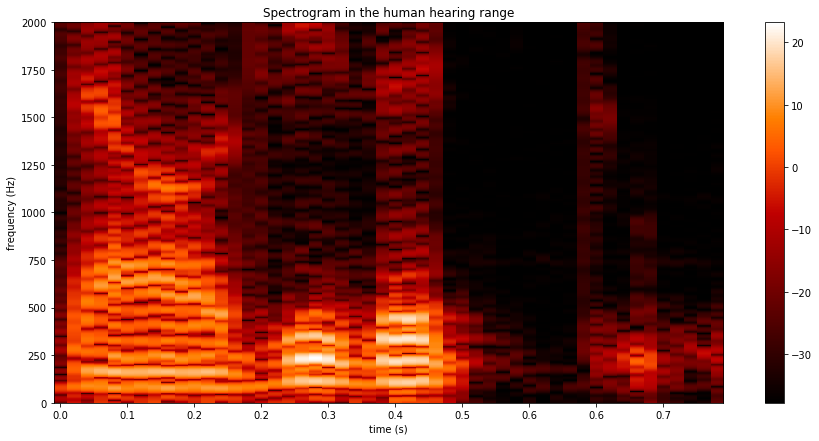

In [2]:
import importlib
from tools import tools
from matplotlib import pyplot as plt
import importlib
importlib.reload(tools)

# sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
sample_rate, wav_data = sp.io.wavfile.read("audio-files/radiolab_crispr.wav")
# sample_rate, wav_data = sp.io.wavfile.read("audio-files/relief.wav")

# filtering out commercials
start_point = 130 * sample_rate

## taking just one channel
audio_data = wav_data[:, 1]
audio_data = audio_data[start_point:]

    
segment_length = int(sample_rate/32)
overlap = int(segment_length / 2)
freq_bins, time_points, spectrogram = tools.generateSpectrogram(
    audio_data, segment_length, sample_rate, overlap, 2000, 180)
specdb = tools.todB(spectrogram + 1)

# plotting
f = tools.plotSpectrogram(specdb[:,0:50], time_points[0:50])

# additional info
dbmax, dbmin = np.max(specdb), np.min(specdb)
dbrange = dbmax - dbmin
print("lenght of audio", len(audio_data))
print("data space size", specdb.shape[0], "by", specdb.shape[1], "totalling", specdb.shape[0] * specdb.shape[1], )

In [27]:
importlib.reload(tools)

limitd = 1000
num_samples = 10000

# angle_constraint_deg=np.array([0, 45, 90, 135])
# distance_constraint = np.full(angle_constraint.shape, np.nan)
angle_constraint_deg=np.arange(0,180,10)
angle_constraint = angle_constraint_deg * (np.pi / 180)
distance_constraint = np.arange(5,100,5)

samples_ac = tools.sample_with_constraint(specdb, num_samples, limitd, angle_constraint=angle_constraint)
samples_dc = tools.sample_with_constraint(specdb, num_samples, limitd, distance_const=distance_constraint)
# base histograms
hist_ac = []
hist_dc = []

def histf(s):
    return np.histogram(s, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)

for i in range(samples_ac.shape[0]):
    s = samples_ac[i]
    h, b = histf(s)
    hist_ac.append(h)

for i in range(samples_dc.shape[0]):
    s = samples_dc[i]
    h, b = histf(s)
    hist_dc.append(h)
    
print("finished")

finished


In [52]:
importlib.reload(tools)
# fig = plt.figure(figsize=(15,10))
# plt.plot(b[1:], h)            
# _discard = plt.legend(np.around(angle_constraint_deg, decimals=0), bbox_to_anchor=(1.12, 1))

# this is what the feature filtering will be based on
num_samples = 10000
hist_divergences = np.zeros((samples_ac.shape[0], samples_dc.shape[0]))

for i in range(samples_ac.shape[0]):
    for j in range(samples_dc.shape[0]):
        ahist = samples_ac[i]
        dhist = samples_dc[j]
        ac = angle_constraint[i]
        dc = distance_constraint[j]
        # limid comes from the cell above
        s = tools.sample_opt_constraint(specdb, num_samples, limitd, angle_constraint=ac, distance_const=dc)
        h,b = histf(s)
        hbase = hist_ac[i] * hist_dc[j]
        hbmin, hbmax = np.min(hbase), np.max(hbase)
        hbr = hbmax - hbmin
        hbase = (hbase - hbmin) / hbr
        
        hmin, hmax = np.min(h), np.max(h)
        hr = hmax - hmin
        hnorm = (h - hmin) / hr
        hist_divergences[i,j] = np.sum(np.abs(hnorm - hbase))
        
print("finished")

finished


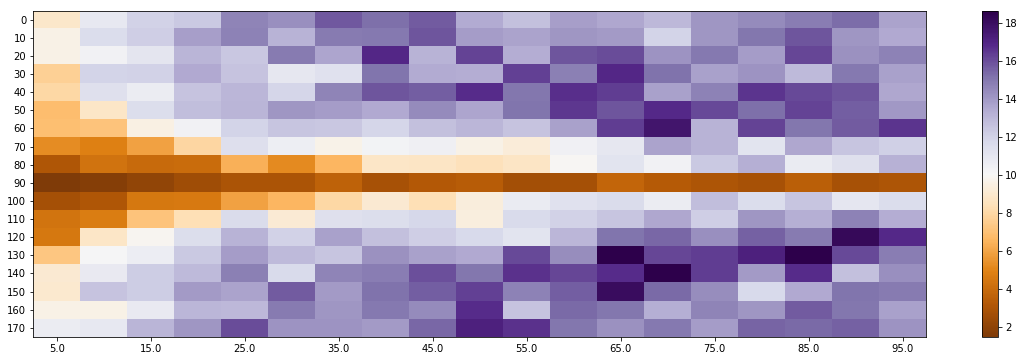

In [53]:
p = np.zeros(hist_divergences.shape)
f = hist_divergences > 0.12
p[f] = hist_divergences[f]

fig = plt.figure(figsize=(20,6))
plt.imshow(p, aspect="auto", cmap=plt.cm.PuOr)
plt.yticks(np.arange(angle_constraint.shape[0]), np.round(angle_constraint_deg,0))

xtpos = np.arange(distance_constraint.shape[0], step=int(np.ceil( distance_constraint.shape[0]/10 )))
plt.xticks(xtpos, np.rint(distance_constraint[xtpos]))
plt.colorbar(orientation='vertical')

# print(hist_divergences)

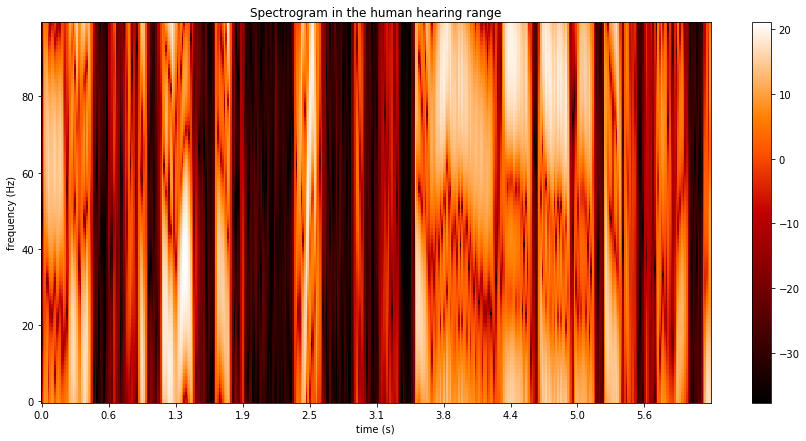

In [41]:
f = tools.plotSpectrogram(specdb[100:200,0:400], time_points[0:400])

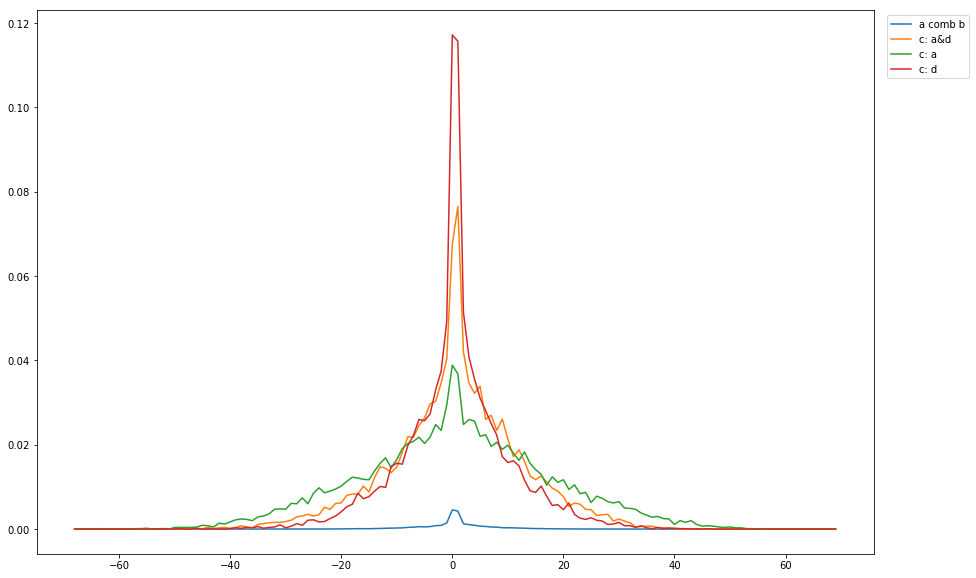

In [47]:
importlib.reload(tools)

limitd = 1000
num_samples = 10000
ac = np.pi / 180 * 0
dc = 3
# sample with the angles constrained
sample_ca = tools.sample_opt_constraint(specdb, num_samples, limitd, angle_constraint=ac)
sample_cd = tools.sample_opt_constraint(specdb, num_samples, limitd, distance_const=dc)
sample_cad = tools.sample_opt_constraint(specdb, num_samples, limitd, angle_constraint=ac, distance_const=dc)

h_ca, b_ca = np.histogram(sample_ca, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
h_cd, b_cd = np.histogram(sample_cd, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
h_cad, b_cad = np.histogram(sample_cad, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)

fig = plt.figure(figsize=(15,10))
plt.plot(b_ca[1:], (h_ca * h_cd) / 1)
plt.plot(b_cad[1:], h_cad)
plt.plot(b_ca[1:], h_ca)
plt.plot(b_ca[1:], h_cd)
# plt.vlines([0,1], 0, np.max(np.concatenate((h_ca, h_cd, h_cad))), linestyles="dotted", colors="#797DB8")
_discard = plt.legend(["a comb b", "c: a&d", "c: a", "c: d"], bbox_to_anchor=(1.12, 1))
# _discard = plt.legend(["a comb b", "c: a&d"], bbox_to_anchor=(1.12, 1))

14.3089532453


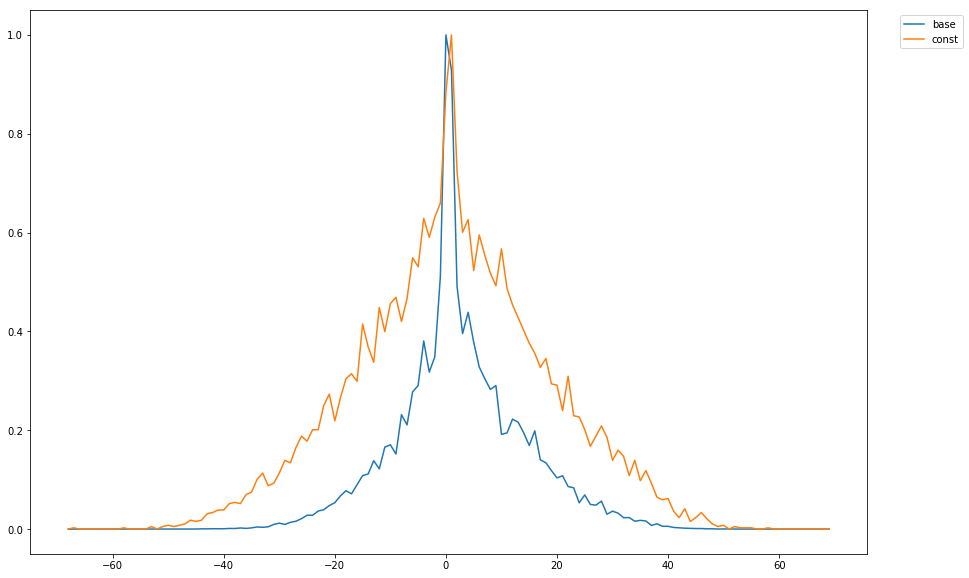

In [56]:
importlib.reload(tools)

limitd = 1000
num_samples = 10000
ac = np.pi / 180 * 120
dc = 90
# sample with the angles constrained
sample_ca = tools.sample_opt_constraint(specdb, num_samples, limitd, angle_constraint=ac)
sample_cd = tools.sample_opt_constraint(specdb, num_samples, limitd, distance_const=dc)
sample_cad = tools.sample_opt_constraint(specdb, num_samples, limitd, angle_constraint=ac, distance_const=dc)

h_ca, b_ca = np.histogram(sample_ca, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
h_cd, b_cd = np.histogram(sample_cd, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)
h_cad, b_cad = np.histogram(sample_cad, bins=int(np.ceil(dbrange*2)), range=(-dbrange, dbrange), density=True)

mult = (h_ca * h_cd)
mn = mult / np.max(mult)
hn_cad = h_cad / np.max(h_cad)
fig = plt.figure(figsize=(15,10))
plt.plot(b_ca[1:],  mn)
plt.plot(b_ca[1:], h_cad / np.max(h_cad))
# plt.plot(b_ca[1:], h_cd * h_cad)
# plt.vlines([0,1], 0, np.max(np.concatenate((h_ca, h_cd, h_cad))), linestyles="dotted", colors="#797DB8")
_discard = plt.legend(["base", "const"], bbox_to_anchor=(1.12, 1))
# _discard = plt.legend(["a comb b", "c: a&d"], bbox_to_anchor=(1.12, 1))
print(np.sum(np.abs(hn_cad - mn)))